# 📘 Growth Curves: Microbial and Cell Population Dynamics> Fit logistic and exponential growth models to biological population data⏱️ **15-25 minutes** | 📊 **Level: ●●○ Intermediate** | 🏷️ **Biology** | 🔬 **Microbiology**---

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/imewei/NLSQ/blob/main/examples/notebooks/04_gallery/biology/growth_curves.ipynb)


In [1]:
# @title Install NLSQ (run once in Colab)
import sys

if 'google.colab' in sys.modules:
    print("Running in Google Colab - installing NLSQ...")
    !pip install -q nlsq
    print("✅ NLSQ installed successfully!")
else:
    print("Not running in Colab - assuming NLSQ is already installed")

Not running in Colab - assuming NLSQ is already installed


## 🔬 Domain Background**Biology System:** Microbial or cell population growth with carrying capacity**Model Equation:**$$N(t) = \frac{K}{1 + (K/N_0 - 1)e^{-rt}}$$**Where:**- $N_0$: Initial population size- $r$: Growth rate (divisions per hour)- $K$: Carrying capacity (maximum population)- $t$: Time (hours)**Common applications:**- 🦠 **Bacterial growth** in culture- 🧫 **Cell culture** expansion- 🌱 **Plant population** ecology- 📊 **Tumor growth** modeling---

## 🎯 What You'll Learn- ✓ Fit logistic growth curves to population data- ✓ Estimate growth rate and carrying capacity- ✓ Distinguish exponential from logistic growth- ✓ Interpret parameters in biological context---

## 📊 Parameter Interpretation Guide| Parameter | Biological Meaning | Typical Range | Units ||-----------|-------------------|---------------|-------|| $N_0$ | Initial population | 10²-10⁶ | cells || $r$ | Doubling rate | 0.5-2.0 | h⁻¹ || $K$ | Carrying capacity | 10⁸-10¹⁰ | cells |**Derived quantities:**- **Doubling time:** $t_d = \ln(2)/r$- **Half-saturation time:** Time to reach K/2---

## Generate Growth Data

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
# MUST come before importing matplotlib
%matplotlib inline

In [3]:
from IPython.display import display

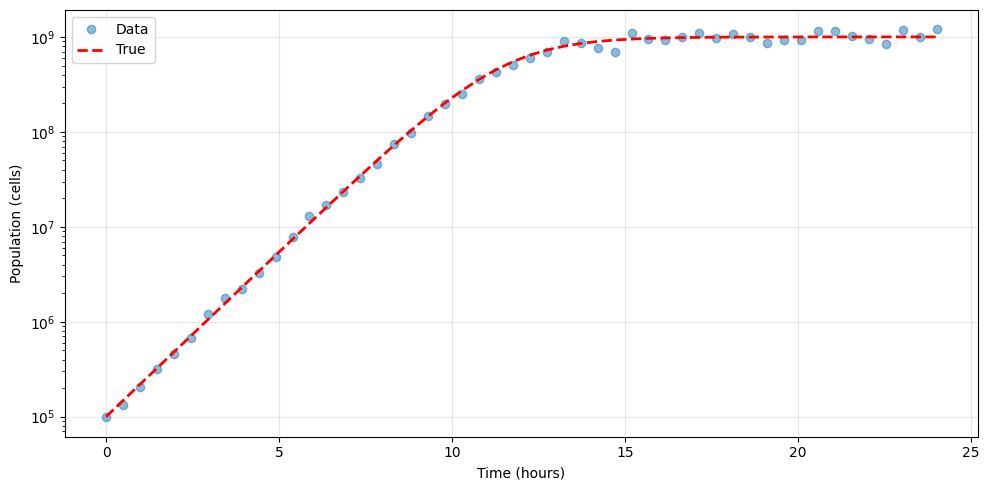

In [4]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

from nlsq import curve_fit


def logistic_growth(t, N0, r, K):
    """Logistic growth model"""
    return K / (1 + (K/N0 - 1) * jnp.exp(-r * t))

# True parameters
N0_true, r_true, K_true = 1e5, 0.8, 1e9

# Generate data
t = np.linspace(0, 24, 50)  # 24 hours
N_true = logistic_growth(t, N0_true, r_true, K_true)
N_measured = N_true * np.exp(np.random.normal(0, 0.1, len(t)))

fig = plt.figure(figsize=(10, 5))
plt.semilogy(t, N_measured, "o", alpha=0.5, label="Data")
plt.semilogy(t, N_true, "r--", label="True", linewidth=2)
plt.xlabel("Time (hours)")
plt.ylabel("Population (cells)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.tight_layout()
plt.show()


## Fit Logistic Model

In [5]:
# Fit
p0 = [1e5, 0.5, 8e8]
bounds = ([1e3, 0.1, 1e7], [1e7, 3.0, 1e11])

popt, pcov = curve_fit(
    logistic_growth, t, N_measured,
    p0=p0, bounds=bounds)

N0_fit, r_fit, K_fit = popt
perr = np.sqrt(np.diag(pcov))

print("Fitted Parameters:")
print(f"  N0 (initial): {N0_fit:.2e} cells")
print(f"  r (growth):   {r_fit:.3f} ± {perr[1]:.3f} h⁻¹")
print(f"  K (capacity): {K_fit:.2e} cells")

# Doubling time
t_double = np.log(2) / r_fit
print(f"\nDoubling time: {t_double:.2f} hours")

INFO:nlsq.curve_fit:Starting curve fit n_params=3 | n_data_points=50 | method=trf | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-08


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.948628s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=14 | final_cost=1.4731e+17 | elapsed=1.949s | final_gradient_norm=8.0078e+12


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=2.738924s


INFO:nlsq.curve_fit:Curve fit completed total_time=2.7389 | final_cost=2.9462e+17 | covariance_warning=False


Fitted Parameters:
  N0 (initial): 2.15e+05 cells
  r (growth):   0.722 ± 0.079 h⁻¹
  K (capacity): 1.02e+09 cells

Doubling time: 0.96 hours


## Visualize Results

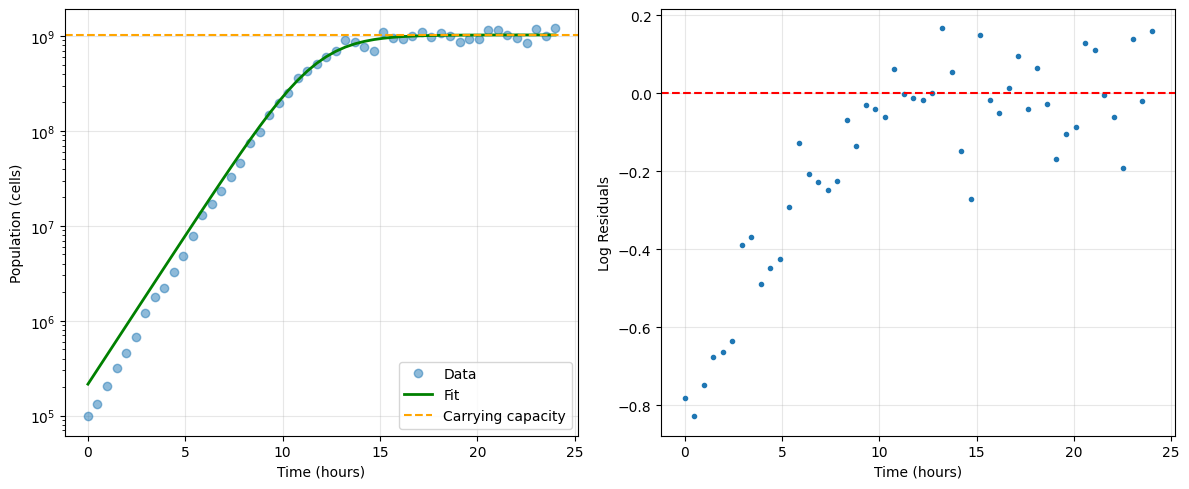

In [6]:
# Plot fit
N_fit = logistic_growth(t, *popt)

fig = plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.semilogy(t, N_measured, "o", alpha=0.5, label="Data")
plt.semilogy(t, N_fit, "g-", linewidth=2, label="Fit")
plt.axhline(K_fit, color="orange", linestyle="--", label="Carrying capacity")
plt.xlabel("Time (hours)")
plt.ylabel("Population (cells)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(122)
residuals = np.log(N_measured) - np.log(N_fit)
plt.plot(t, residuals, ".")
plt.axhline(0, color="r", linestyle="--")
plt.xlabel("Time (hours)")
plt.ylabel("Log Residuals")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.tight_layout()
plt.show()


## 🔑 Key Insights1. **Growth rate determines exponential phase** - Higher r = faster initial growth2. **Carrying capacity limits final population** - K represents resource constraints3. **Inflection point at K/2** - Maximum growth rate occurs at half capacity---

## ⚠️ Domain-Specific Considerations**Lag phase:** Real growth curves often have initial lag- **Solution:** Fit data after lag phase, or use modified model**Stationary phase:** Death rate may equal growth rate- **Solution:** Limit fitting to growth phase only---

## 📚 Related Techniques- [Enzyme Kinetics](enzyme_kinetics.ipynb) - Similar saturation behavior- [Dose Response](dose_response.ipynb) - Sigmoidal curves---

## ❓ Domain-Specific Questions**Q: Why use log scale for population?**A: Exponential growth appears linear on log scale, making it easier to see deviations from exponential behavior.**Q: What if my data does not reach carrying capacity?**A: K will be poorly constrained. Consider exponential model or collect longer time series.---

## 📚 Glossary**Carrying capacity (K):** Maximum sustainable population given available resources**Doubling time:** Time required for population to double in size**Logistic growth:** S-shaped growth with saturation at carrying capacity---